In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import os
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import joblib


import warnings
warnings.filterwarnings('ignore')

In [2]:
Path_Data = '3_merged_data3.txt'

In [3]:
df = pd.read_csv(f"{Path_Data}", sep='\t')
df.head()

,ID,avg7_calingiri,SNOO_500610_1,SNOO_500610_2,SNOO_505150_1,SNOO_104700A_1,SNOO_104700A_2,SNOO_129020A_1,SNOO_129020A_2,SNOO_414470A_1,...,SNOO_526990_1,SNOO_418580A_1,SNOO_508440_1,SNOO_508440_2,SNOO_103660AB_1,SNOO_152090A_1,SNOO_152090A_2,SNOO_007570A_1,SNOO_153580A_1,SNOO_153580A_2
0,14FG141,4.67,0,1,1,0,1,1,0,1,...,0,1,1,0,1,0,0,0,0,1
1,15FG033,4.83,1,0,1,1,0,0,0,1,...,1,1,0,1,1,1,0,0,1,0
2,15FG037,3.33,1,0,1,1,0,0,0,1,...,0,1,0,0,1,1,0,1,1,0
3,15FG038,5.00,1,0,0,1,0,1,0,0,...,1,0,1,0,1,1,0,0,1,0
4,15FG047,2.00,1,0,0,0,1,0,0,1,...,1,1,0,1,1,0,1,0,1,0


## Splitting Data intro Train/ Test

In [4]:
# Separate features and target
X = df.drop(columns=['ID', 'avg7_calingiri'])
y = df['avg7_calingiri']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,  random_state=42
)

print(f"X_train shape: {X_train.shape}")  # 80%
print(f"X_test shape: {X_test.shape}")
    # 20%


X_train shape: (119, 33048)
X_test shape: (30, 33048)


# Bayesian Optimizer

In [5]:


# Define models
def get_models():
    return {
        "Linear Regression": LinearRegression(n_jobs=4),
        "Decision Tree": DecisionTreeRegressor(),
        #"Random Forest": RandomForestRegressor(n_jobs=1),
        #"Gradient Boosting": GradientBoostingRegressor(),
        "Lasso Regression": Lasso(),
    }

# Define scoring metrics
def get_scoring():
    return {
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'R2': make_scorer(r2_score)
    }

# Create Bayesian SearchCV setup
def create_bayesian_searches(X, y, param_spaces, k_values):
    searches = {}
    models = get_models()

    for model_name, model in models.items():
        search_spaces = param_spaces.get(model_name, {})
        if not search_spaces:
            print(f"Skipping {model_name} because search space is empty.")
            continue

        for k in k_values:
            cv = KFold(n_splits=k, shuffle=True, random_state=42)
            search = BayesSearchCV(
                estimator=model,
                search_spaces=search_spaces,
                scoring='r2',
                cv=cv,
                n_iter=32,
                n_jobs=-1,
                verbose=2,
                random_state=42
            )
            key = f"{model_name} (K={k})"
            searches[key] = search

    return searches



In [6]:
param_spaces = {
    "Linear Regression": {},  # no params to tune
    "Decision Tree": {
        "max_depth": Integer(3, 20)  # continuous range from 3 to 20
    },
    #"Random Forest": {
     #   "n_estimators": Integer(50, 200),
      #  "max_depth": Integer(5, 20)
    #},
    #"Gradient Boosting": {
     #   "n_estimators": Integer(50, 200),
      #  "learning_rate": Real(0.01, 0.1, prior='log-uniform')
    #},
    "Lasso Regression": {
        "alpha": Real(0.01, 10.0, prior='log-uniform')
    }
}


In [11]:
from tqdm import tqdm
import time
import os
import joblib
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_with_progress_bayesian(searches, X, y, save_dir="saved_models_bayes"):
    all_results = []

    os.makedirs(save_dir, exist_ok=True)
    total_tasks = len(searches)
    pbar = tqdm(total=total_tasks, desc="Bayesian Training", ncols=100)

    for idx, (name, search) in enumerate(searches.items(), 1):
        print(f"\n🔍 Starting training for: {name}")
        start_time = time.time()

        # Fit model quietly
        search.fit(X, y)

        best_model = search.best_estimator_
        best_params = search.best_params_

        y_pred = best_model.predict(X)

        mean_mse = mean_squared_error(y, y_pred)
        mean_mae = mean_absolute_error(y, y_pred)
        mean_r2  = r2_score(y, y_pred)

        safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("=", "")
        model_path = os.path.join(save_dir, f"{safe_name}.pkl")
        joblib.dump(best_model, model_path)

        elapsed = round(time.time() - start_time, 2)
        print(f"✅ Finished {name} | Time: {elapsed}s | R2: {mean_r2:.4f} | MSE: {mean_mse:.4f}")

        all_results.append({
            "Model": name,
            "Best Params": best_params,
            "MSE": mean_mse,
            "MAE": mean_mae,
            "R2": mean_r2,
            "Training Time (s)": elapsed
        })

        pbar.update(1)

        # Optional: print every 2 or 3 models milestone
        if idx % 3 == 0 or idx == total_tasks:
            print(f"🚀 Progress milestone: {idx}/{total_tasks} models trained.")

    pbar.close()

    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values(by="R2", ascending=False)
    return results_df


In [ ]:
k_values = [3,5,7]
# Create grid searches
searches = create_bayesian_searches(X_train, y_train, param_spaces, k_values)

# Run training
results_df = train_with_progress_bayesian(searches, X_train, y_train)


Skipping Linear Regression because search space is empty.


Bayesian Training:   0%|                                                      | 0/6 [00:00<?, ?it/s]


🔍 Starting training for: Decision Tree (K=3)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 

Bayesian Training:  17%|███████▋                                      | 1/6 [00:32<02:43, 32.79s/it]

✅ Finished Decision Tree (K=3) | Time: 32.79s | R2: 0.8568 | MSE: 0.2307

🔍 Starting training for: Decision Tree (K=5)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 f

Bayesian Training:  33%|███████████████▎                              | 2/6 [01:03<02:06, 31.71s/it]

✅ Finished Decision Tree (K=5) | Time: 30.96s | R2: 0.4771 | MSE: 0.8420

🔍 Starting training for: Decision Tree (K=7)
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 f

Bayesian Training:  50%|███████████████████████                       | 3/6 [01:37<01:37, 32.57s/it]

✅ Finished Decision Tree (K=7) | Time: 33.58s | R2: 0.4771 | MSE: 0.8420
🚀 Progress milestone: 3/6 models trained.

🔍 Starting training for: Lasso Regression (K=3)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 

Bayesian Training:  67%|██████████████████████████████▋               | 4/6 [01:59<00:56, 28.47s/it]

✅ Finished Lasso Regression (K=3) | Time: 22.2s | R2: 0.0000 | MSE: 1.6102

🔍 Starting training for: Lasso Regression (K=5)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totallin

Bayesian Training:  83%|██████████████████████████████████████▎       | 5/6 [02:24<00:27, 27.19s/it]

✅ Finished Lasso Regression (K=5) | Time: 24.92s | R2: 0.0000 | MSE: 1.6102

🔍 Starting training for: Lasso Regression (K=7)
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 7 folds for each of 1 candidates, totalli

Bayesian Training: 100%|██████████████████████████████████████████████| 6/6 [02:56<00:00, 29.47s/it]

✅ Finished Lasso Regression (K=7) | Time: 32.36s | R2: 0.2195 | MSE: 1.2567
🚀 Progress milestone: 6/6 models trained.


In [9]:
results_df.to_csv("model_results.csv", index=False)


### Load best model and predict

In [21]:
import os
import joblib
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

def parse_model_filename(model_name: str) -> str:
    """
    Converts 'Random Forest (K=5)' → 'Random_Forest_K5.pkl'
    """
    import re
    name_clean = model_name.split(" (")[0].replace(" ", "_")
    k_match = re.search(r"K=(\d+)", model_name)
    k_value = f"K{k_match.group(1)}" if k_match else ""
    return f"{name_clean}_{k_value}.pkl"

def evaluate_and_predict_best_model(results_df, X_test, y_test, save_dir="saved_models_bayes"):
    df = results_df.copy()

    # Normalize metrics for combined score
    df["Inv_MSE"] = -df["MSE"]
    df["Inv_MAE"] = -df["MAE"]
    scaler = MinMaxScaler()
    df[["Norm_R2", "Norm_MSE", "Norm_MAE"]] = scaler.fit_transform(df[["R2", "Inv_MSE", "Inv_MAE"]])
    df["Combined_Score"] = df["Norm_R2"] + df["Norm_MSE"] + df["Norm_MAE"]

    # Pick best model
    best_model_info = df.sort_values("Combined_Score", ascending=False).iloc[0]
    model_name = best_model_info["Model"]
    model_file = parse_model_filename(model_name)
    model_path = os.path.join(save_dir, model_file)

    print("🏆 Best Model Info:")
    print(best_model_info[["Model", "R2", "MSE", "MAE", "Combined_Score"]])
    print(f"\n📦 Loading model from: {model_path}")

    # Load and predict
    best_model = joblib.load(model_path)
    y_pred = best_model.predict(X_test)

    # Evaluate
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("\n📊 Evaluation on Test Set:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")

    # Compare predictions
    df_compare = pd.DataFrame({"Actual": y_test[:10], "Predicted": y_pred[:10]})
    print("\n🔍 Actual vs Predicted (First 10 Samples):")
    print(df_compare)

    return best_model_info, y_pred


In [22]:
best_model_info, y_pred = evaluate_and_predict_best_model(results_df, X_test, y_test)


🏆 Best Model Info:
Model             Decision Tree (K=3)
R2                           0.856755
MSE                          0.230651
MAE                          0.311042
Combined_Score                    3.0
Name: 0, dtype: object

📦 Loading model from: saved_models_bayes\Decision_Tree_K3.pkl

📊 Evaluation on Test Set:
R² Score: -0.9792
MAE: 1.2771
MSE: 2.7268

🔍 Actual vs Predicted (First 10 Samples):
     Actual  Predicted
73     4.67   4.808462
18     5.00   3.330000
117    2.33   3.882000
78     3.33   3.000000
76     5.00   3.330000
31     6.00   5.670000
64     4.33   3.123750
140    3.33   4.808462
68     5.33   5.670000
82     6.83   3.330000


## Visualizations

### Model Comparison (Bar Plot of R², MAE, MSE)

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_performance(results_df):
    metrics = ['R2', 'MAE', 'MSE']
    titles = {'R2': 'R² Score', 'MAE': 'Mean Absolute Error', 'MSE': 'Mean Squared Error'}

    plt.figure(figsize=(18, 6))  # Wider figure for 3 subplots

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        sns.barplot(data=results_df, x='Model', y=metric, palette='viridis')
        plt.title(titles[metric])
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()

    plt.suptitle("Model Performance Comparison", fontsize=16, y=1.05)
    plt.show()


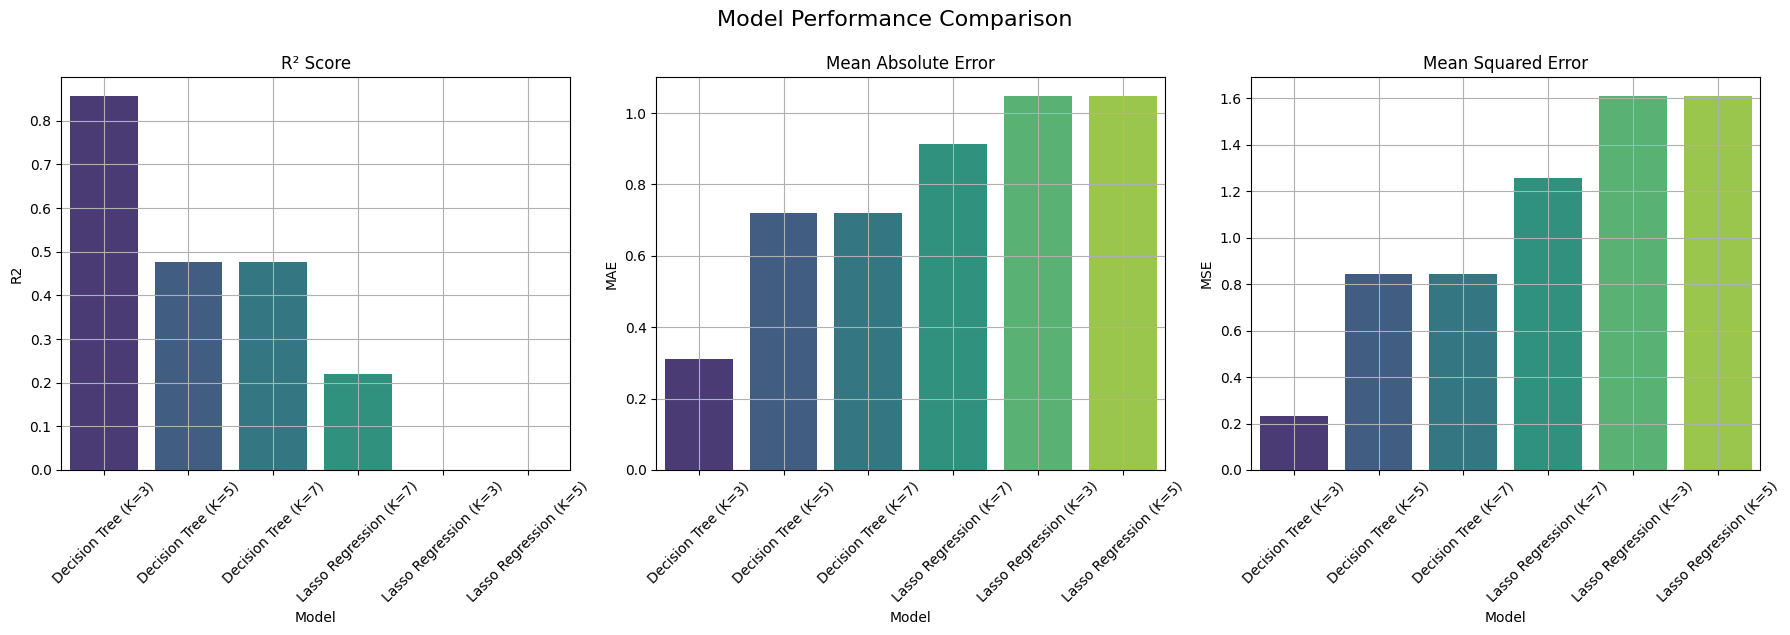

In [24]:
# 1. Bar charts for R2, MAE, MSE
plot_model_performance(results_df)

### Actual vs Predicted (Scatter Plot)

In [25]:
def plot_actual_vs_predicted(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted: {model_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


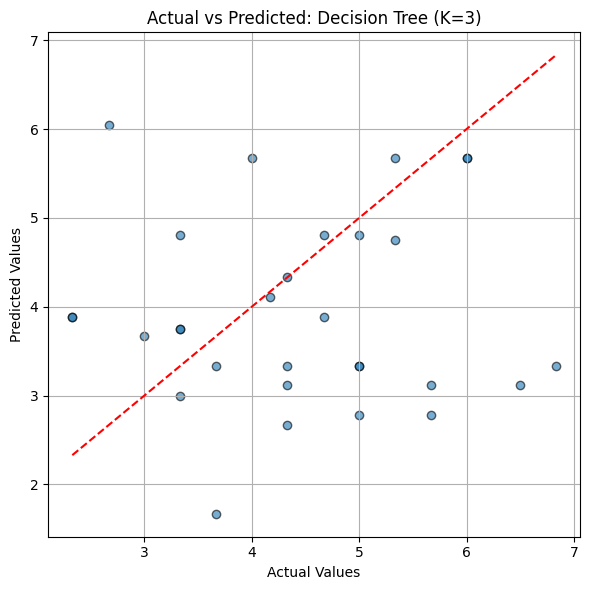

In [26]:
# Plot actual vs predicted
plot_actual_vs_predicted(y_test, y_pred, model_name=best_model["Model"])


### Training Time vs Performance (Bubble Plot)

In [27]:
def plot_time_vs_r2(results_df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=results_df,
        x='Training Time (s)',
        y='R2',
        size='R2',
        hue='Model',
        sizes=(50, 300),
        palette='coolwarm',
        legend=False
    )
    plt.title("Training Time vs R² Score")
    plt.xlabel("Training Time (seconds)")
    plt.ylabel("R² Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


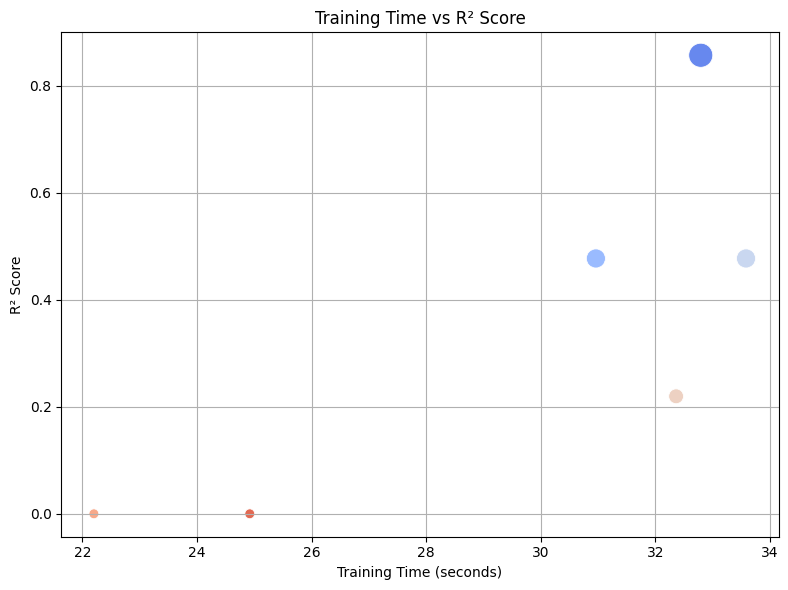

In [28]:
plot_time_vs_r2(results_df)

### Error Distribution Histogram

In [29]:
def plot_error_distribution(y_true, y_pred, model_name="Model"):
    errors = y_true - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(errors, bins=30, kde=True, color='purple')
    plt.title(f"Prediction Error Distribution: {model_name}")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


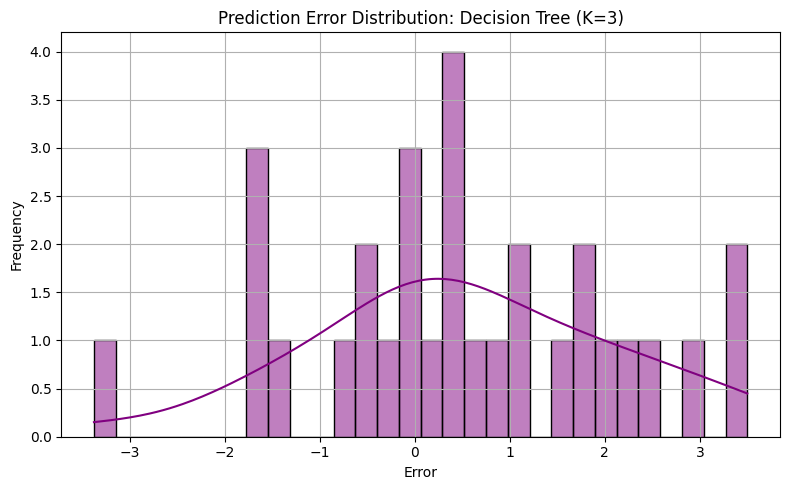

In [30]:
# Assuming you already have y_test and y_pred from the best model
plot_error_distribution(y_test, y_pred, model_name=best_model["Model"])
